In [2]:
import numpy as np
from scipy import stats
from scipy import optimize
from scipy import special
import matplotlib.pyplot as plt

In [280]:
a = 0.16222484
b = 0.09532564640
x_0 = 0.5
n = 100000

# Definindo a função f(x)
def f(x, a, b):
    return np.exp(-a*x) * np.cos(b*x)

#### Crude

In [271]:
def crude(f, a, b, n):
    lista_x = np.random.uniform(low=0, high=1, size=n) # Gera uma amostra uniforme entre 0 e 1 com n elementos
    integral = np.mean(f(lista_x, a, b)) # Calcula a média dos valor de f(x)
    return integral

crude(f, a, b, n)

0.9217930859943684

#### Hit-or-Miss

In [272]:
def hit_or_miss(f, a, b, n):
    acerto = 0 # Mantém conta de quantos pontos estão dentro da área de f(x)

    for _ in range(n):
        x = np.random.uniform(low=0, high=1, size=1) # Gera a coordenada do ponto x [0, 1]
        y = np.random.uniform(low=0, high=1, size=1) # Gera a coordenada do ponto y [0, 1]
        if y < f(x, a, b): # Verifica se está dentro
            acerto += 1

    integral = acerto / n
    return integral

hit_or_miss(f, a, b, n)

0.9216554

#### Importance Sampling

In [290]:
lista_alpha = []
lista_beta = []
lista_k_gamma = []
lista_theta = []
lista_k_weibull = []
lista_lambda = []

# PDF: Probability Density Function
# CDF: Cumulative Density Function
# Divide-se pela CDF avaliada em x = 1 para adapatar as distribuições ao intervalor [0, 1]

def beta(x, alpha, theta):
    return stats.beta.pdf(x, alpha, theta)/stats.beta.cdf(1, alpha, theta)

def gamma(x, shape, scale):
    return stats.gamma.pdf(x, a=shape, scale=scale)/stats.gamma.cdf(1, a=shape, scale=scale)

def weibull(x, shape, scale):
    return stats.weibull_min.pdf(x, c=shape, scale=scale)/stats.weibull_min.cdf(1, c=shape, scale=scale)

def importance_sample(f, a, b, dist, n):
    lista_x = np.random.uniform(low=0, high=1, size=1000000) # Gera valores de x aleatórios
    lista_x = np.sort(lista_x)
    lista_y = f(lista_x, a, b) # Calcula os valores de f(x) correspondentes

    if dist == "beta":
        popt, pcov = optimize.curve_fit(beta, lista_x, lista_y) # Faz o fit por least square
        print(popt)

        y_pred = beta(lista_x, *popt)
        rmse = np.sqrt(np.mean((lista_y - y_pred) ** 2)) # Calcula RMSE
        print("RMSE:", rmse)

        lista_x = []
        while len(lista_x) != n: # Gera pontos segundo a distribuição no intervalo [0, 1] para calcular f(x)/g(x)
            i = stats.beta.rvs(popt[0], popt[1], size=1)
            if i[0] >=0 and i[0] <= 1:
                lista_x.append(i[0])
        lista_x = np.array(lista_x)

        return np.mean(f(lista_x, a, b)/beta(lista_x, popt[0], popt[1]))
    
    elif dist == "gamma":
        popt, pcov = optimize.curve_fit(gamma, lista_x, lista_y) # Faz o fit por least square
        print(popt)

        y_pred = gamma(lista_x, *popt)
        rmse = np.sqrt(np.mean((lista_y - y_pred) ** 2)) # Calcula RMSE
        print("RMSE:", rmse)

        lista_x = []
        while len(lista_x) != n: # Gera pontos segundo a distribuição no intervalo [0, 1] para calcular f(x)/g(x)
            i = stats.gamma.rvs(popt[0], scale=popt[1], size=1)
            if i[0] >=0 and i[0] <= 1:
                lista_x.append(i[0])
        lista_x = np.array(lista_x)

        return np.mean(f(lista_x, a, b)/gamma(lista_x, shape=popt[0], scale=popt[1]))

    elif dist == "weibull":
        popt, pcov = optimize.curve_fit(weibull, lista_x, lista_y) # Faz o fit por least square
        print(popt)

        y_pred = weibull(lista_x, *popt)
        rmse = np.sqrt(np.mean((lista_y - y_pred) ** 2)) # Calcula RMSE
        print("RMSE:", rmse)

        lista_x = []
        while len(lista_x) != n: # Gera pontos segundo a distribuição no intervalo [0, 1] para calcular f(x)/g(x)
            i = stats.weibull_min.rvs(popt[0], scale=popt[1], size=1)
            if i[0] >= 0 and i[0] <= 1:
                lista_x.append(i[0])
        lista_x = np.array(lista_x)

        return np.mean(f(lista_x, a, b)/weibull(lista_x, popt[0], popt[1]))
    
print(importance_sample(f, a, b, "beta", n), importance_sample(f, a, b, "gamma", n), importance_sample(f, a, b, "weibull", n))

[0.9788176  1.02577892]
RMSE: 0.07932503694335659
[1.00039985 6.42510353]
RMSE: 0.07823970512954273
[1.00039789 6.44212331]
RMSE: 0.07823936502848959
0.921815853984504 0.9217480505549881 0.9217552781123334


#### Control Variate

In [287]:
# Definindo o polinômio
def p(x, x_0, f, a, b):
    return f(x_0, a, b) - (a*np.exp(-a*x_0)*np.cos(b*x_0) + b*np.exp(-a*x_0)*np.sin(b*x_0))*(x - x_0)

# Definindo a integral de p(x)
def integral_p(x, x_0, f, a, b):
    return (f(x_0, a, b) + (a*np.exp(-a*x_0)*np.cos(b*x_0) + b*np.exp(-a*x_0)*np.sin(b*x_0))*x_0)*x - (a*np.exp(-a*x_0)*np.cos(b*x_0) + b*np.exp(-a*x_0)*np.sin(b*x_0))*(x**2)/2

def control_variate(f, a, b, p, x_0, n):
    lista_x = np.random.uniform(low=0, high=1, size=n) # Gera valores de x aleatórios
    lista_x = np.sort(lista_x)

    def funcao(f, a, b, p, x, x_0, integral_p): # Função que calcula f(x) - p(x) + integral(p(x) entre 0 e 1)
        parte_1 = f(x, a, b) - p(x, x_0, f, a, b)
        parte_2 = integral_p(1, x_0, f, a, b) - integral_p(0, x_0, f, a, b)
        return parte_1 + parte_2

    lista_resultados = funcao(f, a, b, p, lista_x, x_0, integral_p)

    return np.sum(lista_resultados)/n

control_variate(f, a, b, p, 0.5, n)

0.9217613658378829

### **Definição do Valor de n**

##### Ao obter-se uma amostra aleatória de tamanho $n$, pode-se utilizar a proporção amostral $p_a$ para estimar a proporção populacional $p$.
##### Com n grande, tem-se uma aproximação para uma distribuição normal: $p_a = N(p, \frac{p(1-p)}{n})$. Assim, obtem-se um intervalo de confiança para a proporção populacional (p) (com $\sigma_{p_m} = \sqrt{\frac{p_a \cdot (1 - p_a)}{n}}$):
$$IC_p = \left[p_a - z \cdot \sqrt{\frac{p_a \cdot (1 - p_a)}{n}}, p_a + z \cdot \sqrt{\frac{p_a \cdot (1 - p_a)}{n}}\right]$$
##### Definindo-se a margem de erro ($e$) como metade do tamanho do intervalo de confiança, tem-se que: $$e = z \cdot \sqrt{\frac{p_a \cdot (1 - p_a)}{n}}$$ **$$n = \left(\frac{z}{e}\right)^{2} \cdot p_a \cdot (1 - p_a)$$**

##### Para o valor de $p_a$, pode-se simplesmente estimá-lo ao rodar diversas vezes a simulação e obter uma média dos resultados. Assim, $p_a = \mu$.
##### No entanto, assumindo que não se conhece uma estimativa para o valor de da integral (e, logo, para $p$), assume-se $p_a=0.5$ para obter o maior valor de n possível: **$$n=\left(\frac{z}{e}\right)^{2} \cdot 0.25$$**

###### - $z =$ z-score | $e =$ erro tolerado | $p =$ estimativa pontos dentro/pontos total

##### Como $ \int_{0}^{1} f(x) \,dx = p$, sendo $p = \frac{n_{dentro}}{n_{total}}$, tem-se que $area_{a} = p$ e $\sigma_{area_m} = \sigma_{p_m}$. Assim:
$$IC_{area} = \left[area_a - z \cdot \sqrt{\frac{p_a \cdot (1 - p_a)}{n}}, area_a + z \cdot \sqrt{\frac{p_a \cdot (1 - p_a)}{n}}\right]$$

##### Portanto, analogamente ao processo anterior, tem-se que:
**$$n_{area} = \left(\frac{z}{e}\right)^{2} \cdot p_a \cdot (1 - p_a)$$**

##### Similarmente, no pior dos casos:
**$$n_{area}=\left(\frac{z}{e}\right)^{2} \cdot 0.25$$**

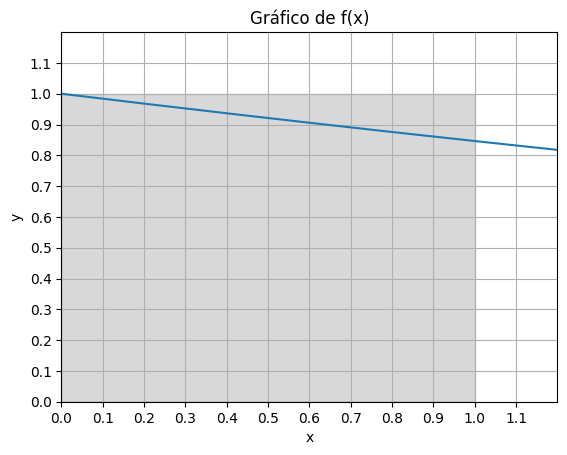

In [247]:
lista_x = np.random.uniform(low=0, high=10, size=100000)
# Ordenar lista_x e lista_y com base em lista_x
lista_x_sorted = np.sort(lista_x)
lista_y_sorted = f(lista_x_sorted, a, b)

# Plotar o gráfico de linha
plt.plot(lista_x_sorted, lista_y_sorted)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gráfico de f(x)')
plt.grid(True)

plt.xlim(0, 1.2)
plt.ylim(0, 1.2)
plt.xticks(np.arange(0, 1.2, 0.1))
plt.yticks(np.arange(0, 1.2, 0.1))

quadrado_x = [0, 0, 1, 1, 0]
quadrado_y = [0, 1, 1, 0, 0]
plt.fill_between(quadrado_x, quadrado_y, color='grey', alpha=0.3)

plt.show()

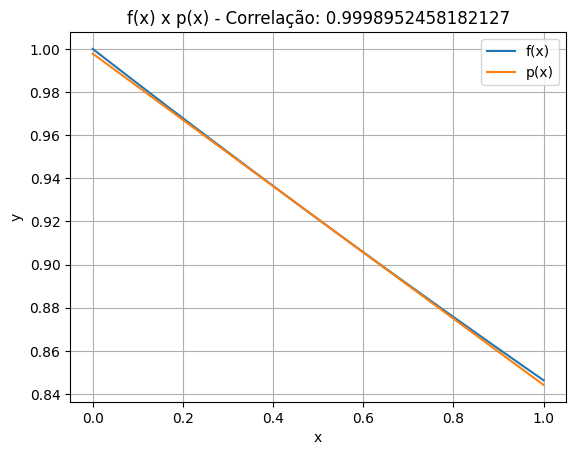

In [286]:
lista_x = np.random.uniform(low=0, high=1, size=100000)
# Ordenar lista_x e lista_y com base em lista_x
lista_x = np.sort(lista_x)
lista_y_f = f(lista_x, a, b)
lista_y_p = p(lista_x, x_0, f, a, b)

correlacao = np.corrcoef(lista_y_f, lista_y_p)[0,1]

# Plotar o gráfico de linha
plt.plot(lista_x, lista_y_f, label="f(x)")
plt.plot(lista_x, lista_y_p, label="p(x)")
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'f(x) x p(x) - Correlação: {correlacao}')
plt.legend()
plt.grid(True)
plt.show()

##### Encontrando os parâmetros ideais para as distribuições e o RMSE

In [299]:
lista_alpha = []
lista_beta = []
lista_k_gamma = []
lista_theta = []
lista_k_weibull = []
lista_lambda = []

# PDF: Probability Density Function
# CDF: Cumulative Density Function
# Divide-se pela CDF avaliada em x = 1 para adapatar as distribuições ao intervalor [0, 1]

def beta(x, alpha, theta):
    return stats.beta.pdf(x, alpha, theta)/stats.beta.cdf(1, alpha, theta)

def gamma(x, shape, scale):
    return stats.gamma.pdf(x, a=shape, scale=scale)/stats.gamma.cdf(1, a=shape, scale=scale)

def weibull(x, shape, scale):
    return stats.weibull_min.pdf(x, c=shape, scale=scale)/stats.weibull_min.cdf(1, c=shape, scale=scale)

def importance_sample(f, a, b, dist, n):
    lista_popt_0 = []
    lista_popt_1 = []
    lista_rmse = []
    for _ in range(n):
        lista_x = np.random.uniform(low=0, high=1, size=10000) # Gera valores de x aleatórios
        lista_x = np.sort(lista_x)
        lista_y = f(lista_x, a, b) # Calcula os valores de f(x) correspondentes

        if dist == "beta":
            popt, pcov = optimize.curve_fit(beta, lista_x, lista_y) # Faz o fit por least square

            y_pred = beta(lista_x, *popt)
            rmse = np.sqrt(np.mean((lista_y - y_pred) ** 2)) # Calcula RMSE

            lista_popt_0.append(popt[0])
            lista_popt_1.append(popt[1])
            lista_rmse.append(rmse)
        
        elif dist == "gamma":
            popt, pcov = optimize.curve_fit(gamma, lista_x, lista_y) # Faz o fit por least square

            y_pred = gamma(lista_x, *popt)
            rmse = np.sqrt(np.mean((lista_y - y_pred) ** 2)) # Calcula RMSE

            lista_popt_0.append(popt[0])
            lista_popt_1.append(popt[1])
            lista_rmse.append(rmse)

        elif dist == "weibull":
            popt, pcov = optimize.curve_fit(weibull, lista_x, lista_y) # Faz o fit por least square

            y_pred = weibull(lista_x, *popt)
            rmse = np.sqrt(np.mean((lista_y - y_pred) ** 2)) # Calcula RMSE

            lista_popt_0.append(popt[0])
            lista_popt_1.append(popt[1])
            lista_rmse.append(rmse)

    print([np.mean(lista_popt_0), np.mean(lista_popt_1), np.mean(lista_rmse)])
    return [np.mean(lista_popt_0), np.mean(lista_popt_1), np.mean(lista_rmse)]
    
print(importance_sample(f, a, b, "beta", 1000), importance_sample(f, a, b, "gamma", 1000), importance_sample(f, a, b, "weibull", 1000))

[0.9788256818982228, 1.0257397447007375, 0.07931965354227562]
[1.0002706946318172, 6.47503086049205, 0.07823223676712485]
[1.000251913193641, 6.487859164365142, 0.07823207213520332]
[0.9788256818982228, 1.0257397447007375, 0.07931965354227562] [1.0002706946318172, 6.47503086049205, 0.07823223676712485] [1.000251913193641, 6.487859164365142, 0.07823207213520332]
